In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import os
import sys
sys.path.append('./src')

In [2]:
import pandas as pd
import numpy as np

# Get Data

In [3]:
import get_data 
train_all_data, test_all_data = get_data.get_cardiotoxnet_data()

train data contains 12620 compounds:
	6643 hERG blockers and 5977 non-blockers
test_0 contains 44 compounds:
	30 hERG blockers and 14 non-blockers
test_1 contains 41 compounds:
	11 hERG blockers and 30 non-blockers
test_2 contains 740 compounds:
	34 hERG blockers and 706 non-blockers


In [4]:
random_state = 42
test_percent = 0.2
smiles_column = 'smiles'
train_data, val_data = get_data.split_data(train_all_data, smiles_column, test_percent=0.2, random_state=random_state)

Training set size: 9989
Validation set size: 2631


In [5]:
train_data.head()

,ACTIVITY,smiles,ABC,ABCGG,nAcid,nBase,nAromAtom,nAromBond,nAtom,nHeavyAtom,...,SRW09,SRW10,TSRW10,MW,AMW,WPath,WPol,Zagreb1,Zagreb2,mZagreb2
0,1,Fc1ccc(-n2cc(NCCN3CCCCC3)nn2)cc1F,17.108462,13.312773,0,1,11,11,41,22,...,6.580639,9.781828,69.261944,307.160852,7.491728,1258,29,112,128,4.888889
1,0,COc1cc(N2Cc3ccc(Sc4ccc(F)cc4)nc3C2=O)ccc1OCCN1...,26.886637,19.283801,0,1,18,18,60,34,...,7.412764,10.412922,86.178228,479.167891,7.986132,4035,52,182,215,7.472222
2,0,CCOC(=O)[C@H]1CC[C@@H](N2CC(NC(=O)CNc3nn(C(N)=...,28.187229,20.640811,0,1,9,10,65,36,...,7.050123,10.607303,87.262633,510.220238,7.849542,4957,56,192,226,7.750000
3,0,N[C@@H](Cn1c(=O)cnc2ccc(F)cc21)C1CCC(NCc2ccc3c...,27.105416,18.346730,0,2,16,17,61,34,...,0.000000,10.500041,70.568018,466.212867,7.642834,4122,56,184,217,7.305556
5,0,Cc1cc(Nc2cncc(N[C@@H](C)c3ncc(F)cn3)n2)n[nH]1,17.965399,14.197055,0,0,17,17,38,23,...,6.529419,9.823957,70.453602,314.140371,8.266852,1353,30,118,134,5.027778


In [6]:
val_data.head()

,ACTIVITY,smiles,ABC,ABCGG,nAcid,nBase,nAromAtom,nAromBond,nAtom,nHeavyAtom,...,SRW09,SRW10,TSRW10,MW,AMW,WPath,WPol,Zagreb1,Zagreb2,mZagreb2
4,0,O=C(NC1COc2cccc(-c3ccnc(CO)c3)c2C1)c1ccc(OCC(F...,25.880229,18.463716,0,0,18,18,53,33,...,0.000000,10.391239,69.196044,459.140591,8.663030,3658,51,174,201,7.152778
6,0,C[N+]1CC[N+](CCCN2c3ccccc3Sc3ccc(Cl)cc32)CC1,19.856009,14.567550,0,2,12,12,49,25,...,0.000000,10.204962,60.016070,373.136849,7.615038,1544,40,134,158,5.444444
8,1,O=C(c1ccncc1)N1CCC2(CCN(Cc3cccc(Oc4ccccc4)c3)C...,26.191460,17.210284,0,1,18,18,64,33,...,0.000000,10.397421,69.250668,441.241627,6.894400,3896,51,176,205,7.222222
9,0,COc1ccc(-c2cc(-c3ccc(C(=O)N(C)C)cc3)cnc2N)cn1,20.034348,15.337941,0,0,18,18,46,26,...,0.000000,10.129706,60.902190,348.158626,7.568666,1827,42,134,157,5.805556
12,1,Cc1ccc(NC(=O)N[C@@H]2N=C(c3ccccc3)c3ccccc3N(C)...,23.529442,18.178191,0,0,18,18,52,30,...,5.459586,10.281821,73.857434,398.174276,7.657198,2431,52,158,186,6.583333


# ChemBERTa based model

In [7]:
from transformers import RobertaTokenizer
model_path = "./huggingface/ChemBERTa-77M-MLM"
tokenizer = RobertaTokenizer.from_pretrained(model_path)

def tokenize_function(smiles_list):
    return tokenizer(smiles_list, padding='max_length', truncation=True, max_length=128)

train_encodings = tokenize_function(train_data['smiles'].tolist())
val_encodings = tokenize_function(val_data['smiles'].tolist())


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [8]:
import torch

class Dataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_labels = train_data['ACTIVITY'].tolist()
val_labels = val_data['ACTIVITY'].tolist()

train_dataset = Dataset(train_encodings, train_labels)
val_dataset = Dataset(val_encodings, val_labels)


## load the model

In [9]:
from transformers import RobertaForSequenceClassification

model = RobertaForSequenceClassification.from_pretrained(model_path, num_labels=2)


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at ./huggingface/ChemBERTa-77M-MLM and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## traing the model

In [10]:
from torch.utils.data import DataLoader
from transformers import AdamW, get_scheduler
from sklearn.metrics import accuracy_score, f1_score

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)

optimizer = AdamW(model.parameters(), lr=5e-5)

num_epochs = 20
num_training_steps = num_epochs * len(train_loader)
lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps
)

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)


train_losses = []
val_losses = []

best_val_loss = float('inf')
best_model_dir = 'best_chemberta_herg_model'

if not os.path.exists(best_model_dir):
    os.makedirs(best_model_dir)


for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for batch in train_loader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss # cross-entropy loss
        loss.backward()

        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        train_loss += loss.item()
    
    avg_train_loss = train_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    
    model.eval()
    val_loss = 0
    predictions = []
    true_labels = []
    
    with torch.no_grad():
        for batch in val_loader:
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            loss = outputs.loss
            logits = outputs.logits
            val_loss += loss.item()
            predictions.extend(torch.argmax(logits, dim=-1).cpu().numpy())
            true_labels.extend(batch['labels'].cpu().numpy())

    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    
    print(f'Epoch {epoch + 1}/{num_epochs}: Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss}')
    
    
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        model.save_pretrained(best_model_dir)
        tokenizer.save_pretrained(best_model_dir)
        print(f'Saved best model with validation loss: {best_val_loss}')
    

Epoch 1/20: Training Loss: 0.6120, Validation Loss: 0.5620098090461685
Saved best model with validation loss: 0.5620098090461685
Epoch 2/20: Training Loss: 0.5077, Validation Loss: 0.563314681221649
Epoch 3/20: Training Loss: 0.4615, Validation Loss: 0.5449736199389837
Saved best model with validation loss: 0.5449736199389837
Epoch 4/20: Training Loss: 0.4261, Validation Loss: 0.557072337750787
Epoch 5/20: Training Loss: 0.4030, Validation Loss: 0.5635733686296954
Epoch 6/20: Training Loss: 0.3712, Validation Loss: 0.573351968827128
Epoch 7/20: Training Loss: 0.3458, Validation Loss: 0.5921924246593993
Epoch 8/20: Training Loss: 0.3332, Validation Loss: 0.589735292283235
Epoch 9/20: Training Loss: 0.3108, Validation Loss: 0.6288277801567842
Epoch 10/20: Training Loss: 0.2983, Validation Loss: 0.6446513537102376
Epoch 11/20: Training Loss: 0.2822, Validation Loss: 0.6734623156974834
Epoch 12/20: Training Loss: 0.2717, Validation Loss: 0.6592214081640211
Epoch 13/20: Training Loss: 0.258

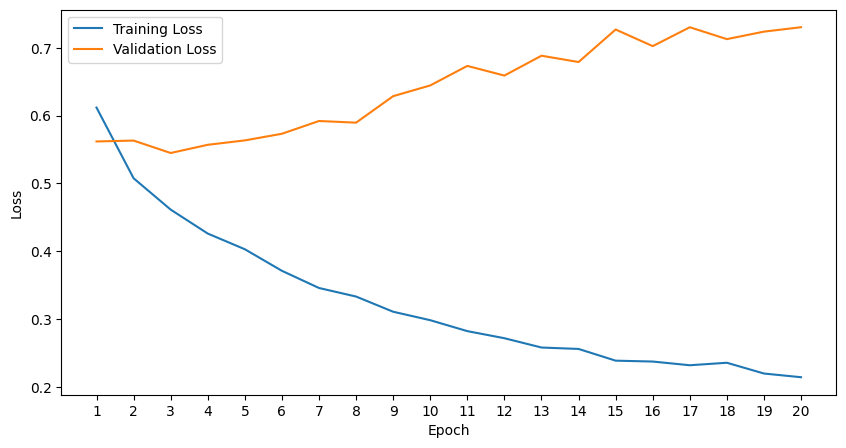

In [14]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
epochs = range(1, num_epochs + 1)
plt.plot(epochs, train_losses, label='Training Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xticks(epochs)
plt.legend()
plt.show()

## Evaluate model on test data

In [16]:
from transformers import RobertaForSequenceClassification, RobertaTokenizer

# Load the best model and tokenizer
model = RobertaForSequenceClassification.from_pretrained(best_model_dir)
tokenizer = RobertaTokenizer.from_pretrained(best_model_dir)
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(600, 384, padding_idx=1)
      (position_embeddings): Embedding(515, 384, padding_idx=1)
      (token_type_embeddings): Embedding(1, 384)
      (LayerNorm): LayerNorm((384,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.144, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-2): 3 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=384, out_features=384, bias=True)
              (key): Linear(in_features=384, out_features=384, bias=True)
              (value): Linear(in_features=384, out_features=384, bias=True)
              (dropout): Dropout(p=0.109, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=384, out_features=384, bias=True)
             

In [18]:
from evaluate import eval

for i, test_data in enumerate(test_all_data):
    print(f"\n== Testing on data set {i} ==")
    test_encodings = tokenize_function(test_data['smiles'].tolist())
    test_labels = test_data['ACTIVITY'].tolist()
    test_dataset = Dataset(test_encodings, test_labels)
    test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

    predictions = []
    true_labels = []

    with torch.no_grad():
        for batch in test_loader:
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            logits = outputs.logits
            predictions.extend(torch.argmax(logits, dim=-1).cpu().numpy())
            true_labels.extend(batch['labels'].cpu().numpy())
    
    eval(true_labels, predictions, verbose=True)
    


== Testing on data set 0 ==
Accuracy: 0.7272727272727273
ROC AUC Score: 0.7047619047619047
Precision: 0.8214285714285714
Recall: 0.7666666666666667
F1 Score: 0.793103448275862
Matthews Correlation Coefficient: 0.3965197235402832
Specificity (Negative Prediction Accuracy): 0.6428571428571429

== Testing on data set 1 ==
Accuracy: 0.6585365853658537
ROC AUC Score: 0.7378787878787878
Precision: 0.43478260869565216
Recall: 0.9090909090909091
F1 Score: 0.5882352941176471
Matthews Correlation Coefficient: 0.4247589239364156
Specificity (Negative Prediction Accuracy): 0.5666666666666667

== Testing on data set 2 ==
Accuracy: 0.6932432432432433
ROC AUC Score: 0.6432677887018831
Precision: 0.08583690987124463
Recall: 0.5882352941176471
F1 Score: 0.149812734082397
Matthews Correlation Coefficient: 0.12916308882744168
Specificity (Negative Prediction Accuracy): 0.6983002832861189


In [23]:
test_encodings

transformers.tokenization_utils_base.BatchEncoding